In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import svm


In [2]:
img = plt.imread('media/goal.jpg')

classes = None
with open('coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]


Width = img.shape[1]
Height = img.shape[0]

In [3]:
# read pre-trained model and config file
net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')

In [4]:
# create input blob 
# set input blob for the network
net.setInput(cv2.dnn.blobFromImage(img, 0.00392, (416,416), (0,0,0), True, crop=False))

# run inference through the network
# and gather predictions from output layers

layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
outs = net.forward(output_layers)

In [5]:
class_ids = []
confidences = []
boxes = []


In [23]:
# #First I identified the range for the three colors.
# color_list=["yellow","red","black"]
# boundaries = [
#     ((181,166,66), (255,255,240)), #yellow
#     ((130, 45, 45), (50, 56, 200)), #red
#     ((0,0,0),(20,20,20)) #black
#     ]
# mask=[]
# #Then I applied OpenCV’s inRange function to create masks for three colors.
# for i in range(len(color_list)):
#     lower=boundaries[i][0]
#     upper=boundaries[i][1]
#    # mask.append(cv2.inRange(image, lower, upper))


#     if i==1:
#         lower = np.array([155,25,0])
#         upper = np.array([179,255,255]) 
#     #     # lower mask (0-10)
#     #     lower_red = np.array([0,50,50])
#     #     upper_red = np.array([10,255,255])
#     #     mask0 = cv2.inRange(image, lower_red, upper_red)

#     #     # upper mask (170-180)
#     #     lower_red = np.array([160,50,50])
#     #     upper_red = np.array([180,255,255])
#     #     mask1 = cv2.inRange(image, lower_red, upper_red)

#     #     # join my masks
#     #     mask = mask0+mask1
#     mask=cv2.inRange(image, lower, upper)
#     output = cv2.bitwise_and(image, image, mask = mask)
#     fig = plt.figure(figsize=(20,10))
#     ax1 = fig.add_subplot(1,1,1)
#     ax1.imshow(output)
#     plt.title(f"{color_list[i]}")
    

In [24]:
# #Then use bitwise_and to apply masks to the frame.
# output = cv2.bitwise_and(image, image, mask = mask)
# #Three colors are extracted now

In [25]:
# #Now we need to apply these mask to the detection.
# # I cropped the image based on the bounding box detected then applied the masks.
# crop_img = frame[ymin:ymax, xmin:xmax]

In [6]:
#create bounding box 
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.1:
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = center_x - w / 2
            y = center_y - h / 2
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h])

In [9]:
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.1, 0.1)
print("==>> indices.shape: ", indices.shape)

==>> indices.shape:  (20,)


In [10]:
#check if is people detection
player_number=0
u_im=[] # player postion
boxes_player=[]
for i in indices:
    box = boxes[i]
    if class_ids[i]==0:
        boxes_player.append(box)

        label = str(f"player{player_number}") 
        player_number +=1
        cv2.rectangle(img, (round(box[0]),round(box[1])), (round(box[0]+box[2]),round(box[1]+box[3])), (0, 0, 0), 2)
        cv2.putText(img, label, (round(box[0])-10,round(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
        bottom_right_corner=(round(box[0]+box[2]),round(box[1]+box[3]))
        u_im.append(bottom_right_corner)

Text(0.5, 1.0, 'detection')

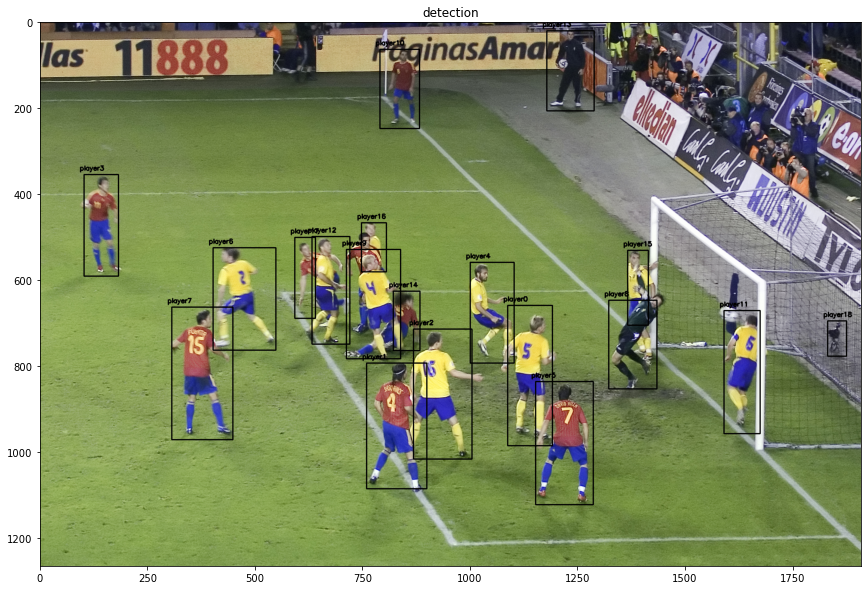

In [11]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(img)
plt.title("detection")
#

import the coordinates of the players to the calibration script

In [12]:
import csv
with open('GFG.csv', 'w',newline='') as outfile:
    writer = csv.writer(outfile)
    #writer.writerow(["",""])
    writer.writerows(u_im)

This calibration works only for this photo, but i will make it work for other photos.

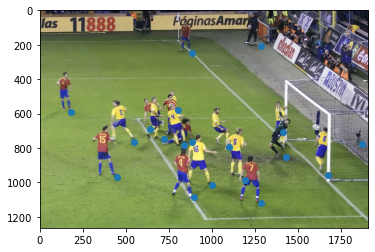

ValueError: shapes (3,3) and (19,2) not aligned: 3 (dim 1) != 19 (dim 0)

In [13]:
%run ./calibration.py 

K-means for team identification


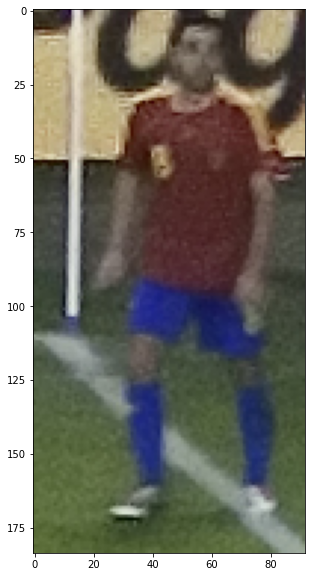

In [18]:
p=10


def get_cropped_box(box):  
    player_crop=img[round(box[1]):round(box[1]+box[3]),round(box[0]):round(box[0]+box[2])]
    return player_crop
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(get_cropped_box(boxes_player[p]))

def get_team(box):
    box=get_cropped_box(box)
    image = Image.fromarray(box,'RGB')
    pixels = np.array(list(image.getdata()))
    #fit KMeans and get centroids
    kmeans = KMeans(n_clusters = 2)
    kmeans = kmeans.fit(pixels)
    centroids = kmeans.cluster_centers_
    return kmeans, centroids

def show_clusters(i):
    clusters=get_team(boxes_player[i])[1]
    # w=(boxes[i])[2]
    # h=(boxes[i])[3]
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow([[(int(clusters[0,0]), int(clusters[0,1]), int(clusters[0,2]))]])
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow([[(int(clusters[1,0]), int(clusters[1,1]), int(clusters[1,2]))]])
    # ax3 = fig.add_subplot(1,3,3)
    # ax3.imshow([[(int(clusters[2,0]), int(clusters[2,1]), int(clusters[2,2]))]])
    #print(clusters[0])
    
# show_clusters(p)
#dprint(get_team(boxes[4]))


REmove background


In [10]:
# # load image
# #img = cv2.imread('person.png')
# img=get_cropped_box(boxes_player[p])#crop image

# # convert to graky
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# # threshold input image as mask
# mask = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)[1]

# # negate mask
# mask = 255 - mask

# # apply morphology to remove isolated extraneous noise
# # use borderconstant of black since foreground touches the edges
# kernel = np.ones((3,3), np.uint8)
# mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
# mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# # anti-alias the mask -- blur then stretch
# # blur alpha channel
# mask = cv2.GaussianBlur(mask, (0,0), sigmaX=2, sigmaY=2, borderType = cv2.BORDER_DEFAULT)

# # linear stretch so that 127.5 goes to 0, but 255 stays 255
# mask = (2*(mask.astype(np.float32))-255.0).clip(0,255).astype(np.uint8)

# # put mask into alpha channel
# result = img.copy()
# result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
# result[:, :, 3] = mask

# # save resulting masked image
# cv2.imwrite('person_transp_bckgrnd.png', result)

# # display result, though it won't show transparency
# cv2.imshow("INPUT", img)
# cv2.imshow("GRAY", gray)
# cv2.imshow("MASK", mask)
# cv2.imshow("RESULT", result)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

the dominant colors of image0[[110.53021459 118.21223176  88.17103004]
 [223.03451528 210.95954357 124.47831007]]
the dominant colors of image1[[114.03637788 112.47397775  97.14551151]
 [200.14177356 196.7147797  161.05889571]]
the dominant colors of image2[[109.56924765 122.43791757  87.00990866]
 [233.30904946 224.70413321 136.89860244]]
the dominant colors of image3[[140.753285   149.06154659  96.59726627]
 [ 80.56527137  67.31252217 112.33965945]]
the dominant colors of image4[[117.3999673  133.30317728  79.28208622]
 [211.08914658 206.05200217 141.12447907]]
the dominant colors of image5[[106.82759231 102.77462546  86.72732099]
 [205.70289855 194.04461051 155.72214674]]
the dominant colors of image6[[128.71402837 146.42693087  92.54762441]
 [216.97716613 210.11676129 130.69624784]]
the dominant colors of image7[[149.41420407 150.59083399  97.43736288]
 [ 60.17383013  64.9907584  124.61977409]]
the dominant colors of image8[[ 50.99463852  61.71115021  53.92661473]
 [143.67319264 15

C:\Users\HAMZAO~1\AppData\Local\Temp/ipykernel_9088/1759934385.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,10))


the dominant colors of image10[[173.80502959 166.08550296 141.22721893]
 [ 75.33281665  72.97379687  64.66157366]]
the dominant colors of image11[[ 89.46161417  95.93686727 100.80539933]
 [206.40142857 200.99469388 156.95673469]]
the dominant colors of image12[[158.4670105  164.93553054 102.45141204]
 [ 69.72365186  68.87756106  81.80937551]]
the dominant colors of image13[[ 51.34535388  47.15023193  47.7665719 ]
 [133.44530589 125.55539893 112.71440654]]
the dominant colors of image14[[ 79.95751988  72.07086045  57.11532899]
 [155.92261905 158.05720899 104.50066138]]
the dominant colors of image15[[197.84898763 192.92463442 137.83183352]
 [ 74.28794829  84.70016681  82.09361968]]
the dominant colors of image16[[129.04361055 123.03955375  71.28017241]
 [199.00937031 181.61656672 142.55509745]]
the dominant colors of image17[[174.61442441 170.47803976 141.38049006]
 [134.25273284 138.58431715  78.39571491]]
the dominant colors of image18[[ 54.57002457  54.0990991   65.21539722]
 [122.05

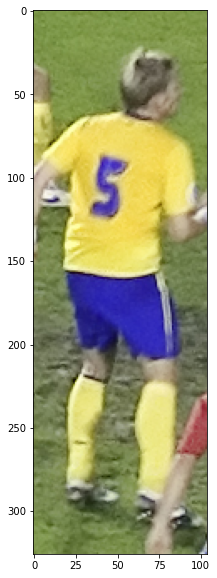

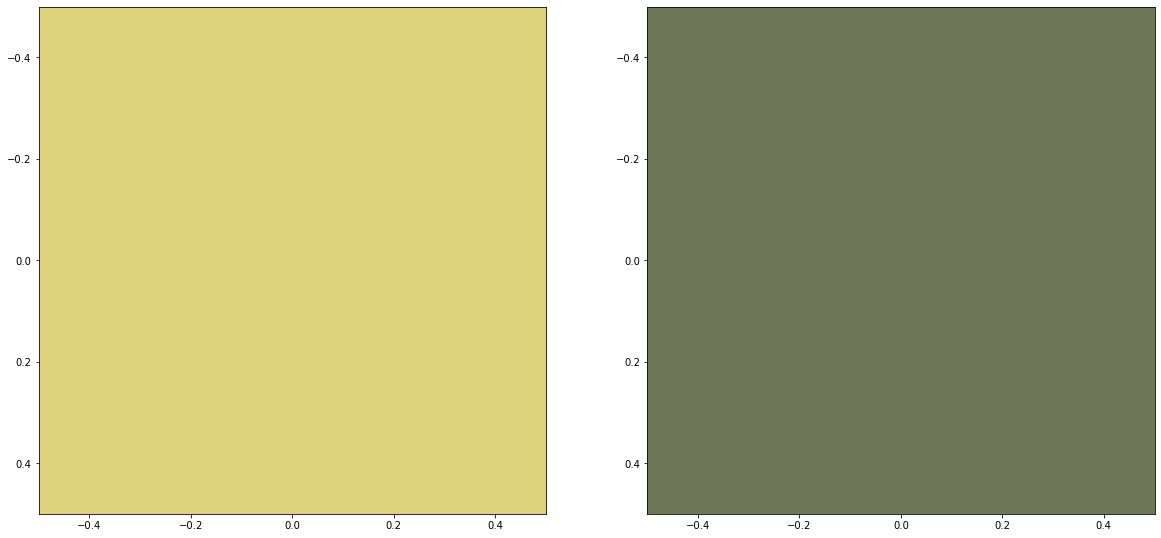

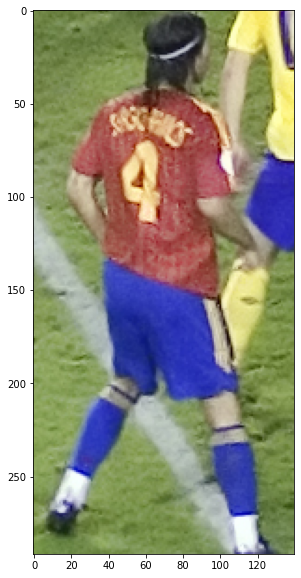

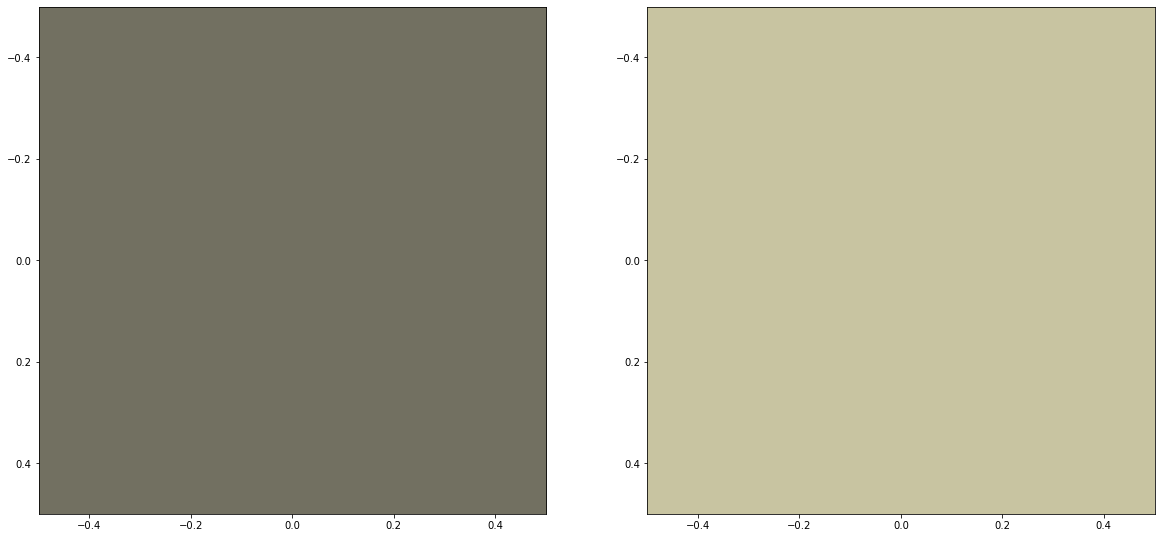

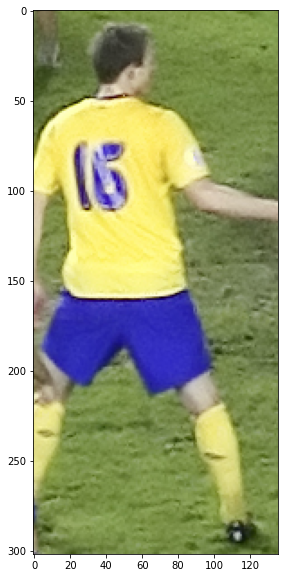

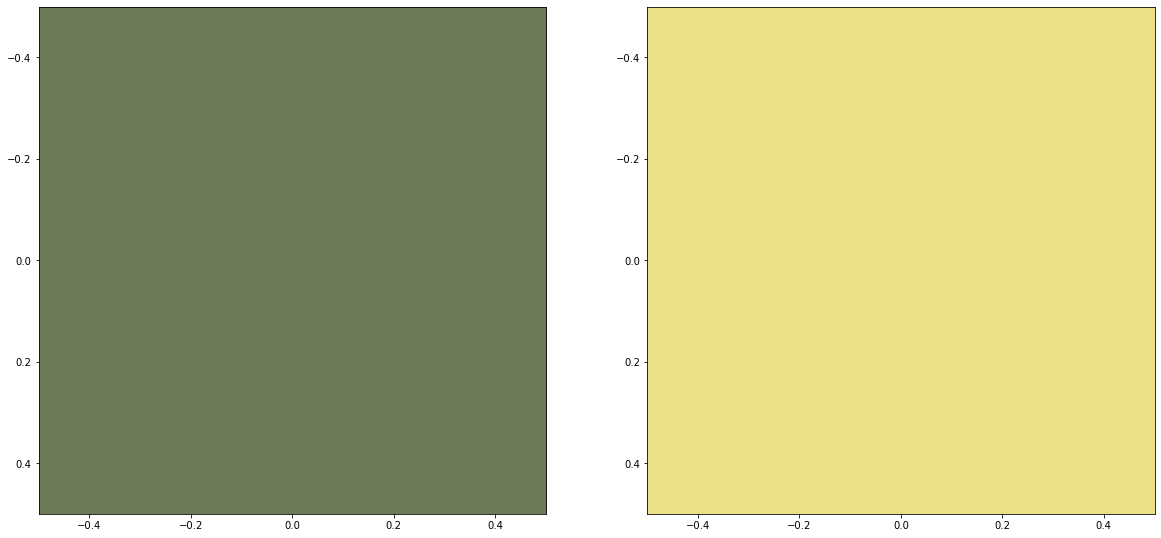

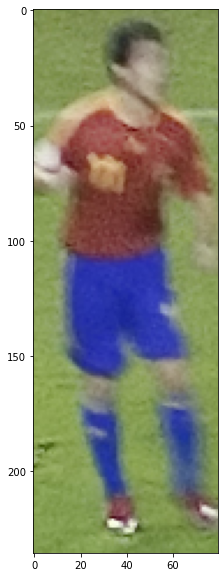

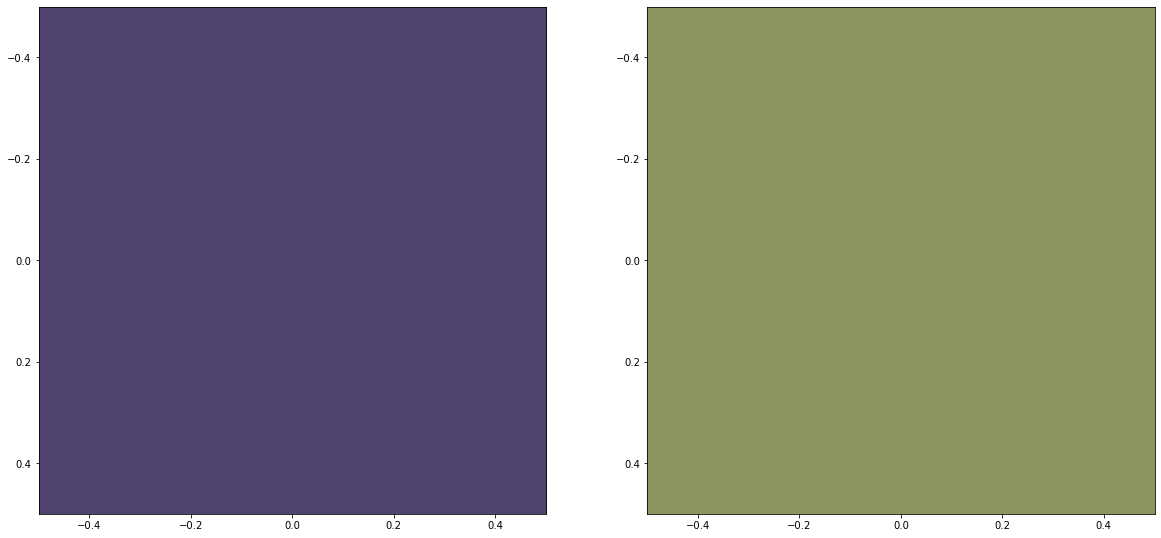

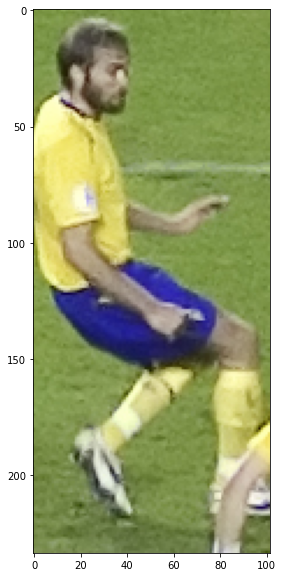

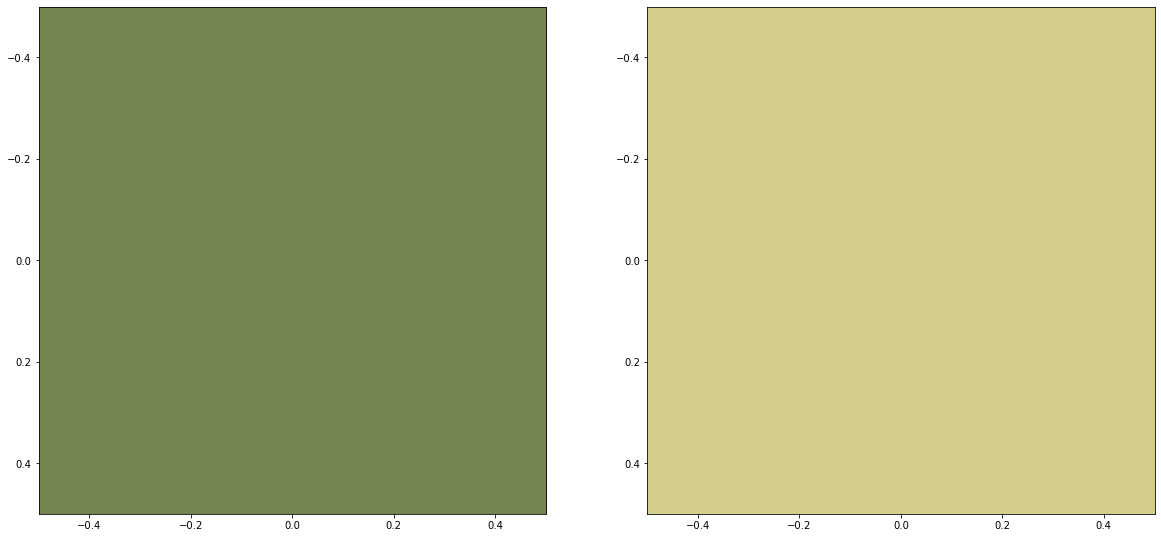

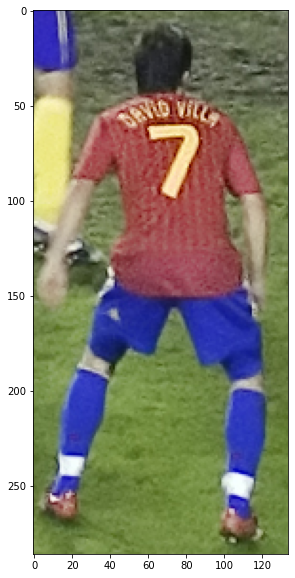

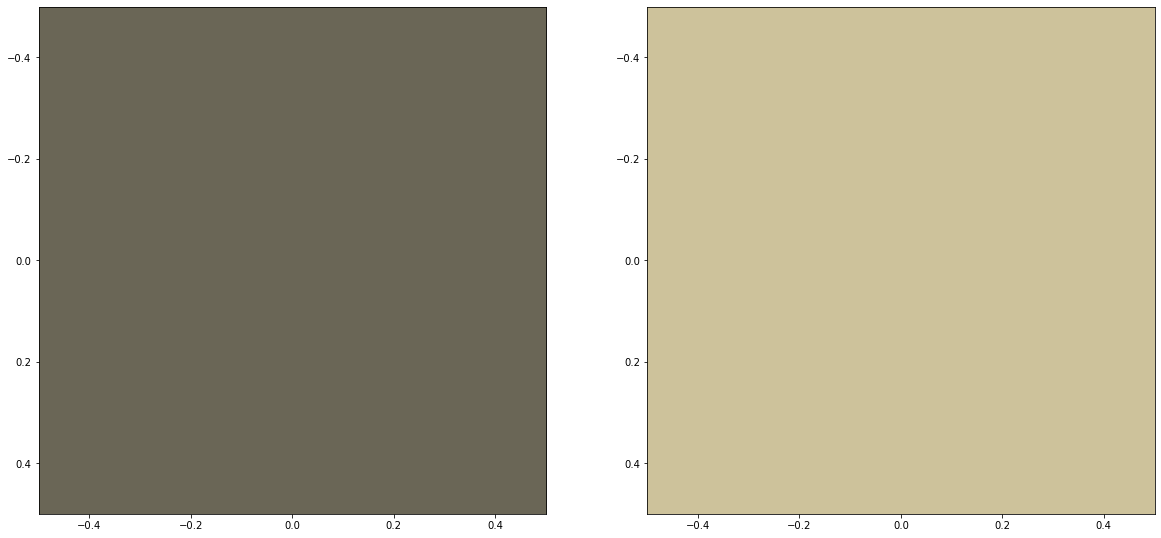

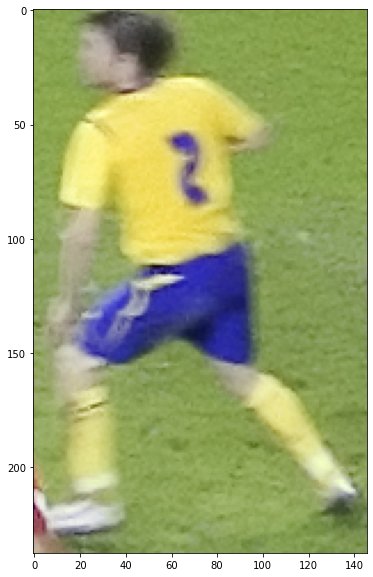

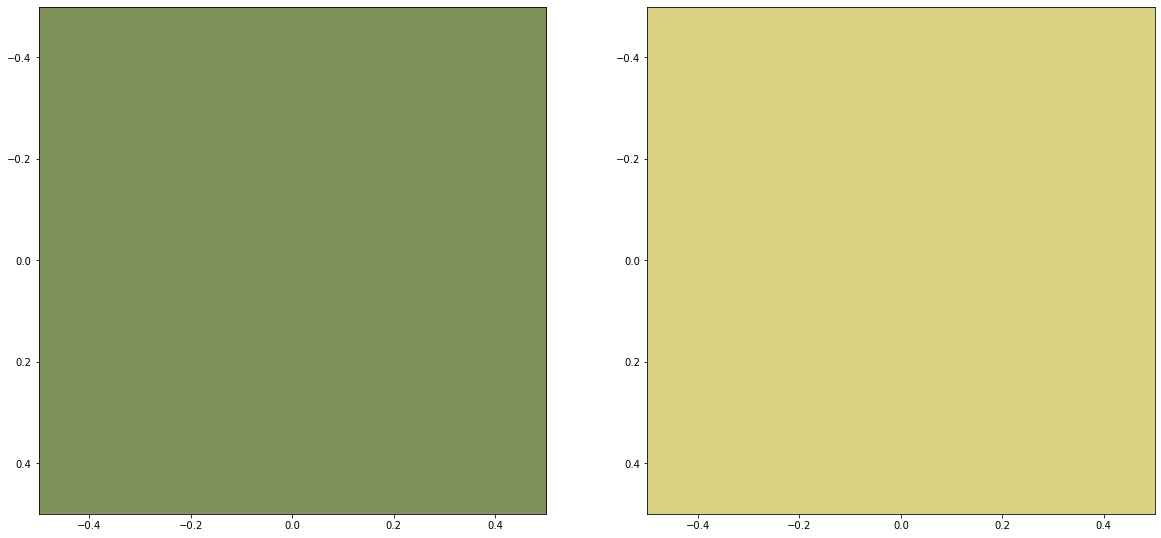

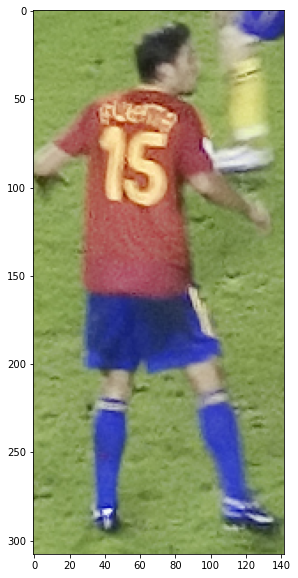

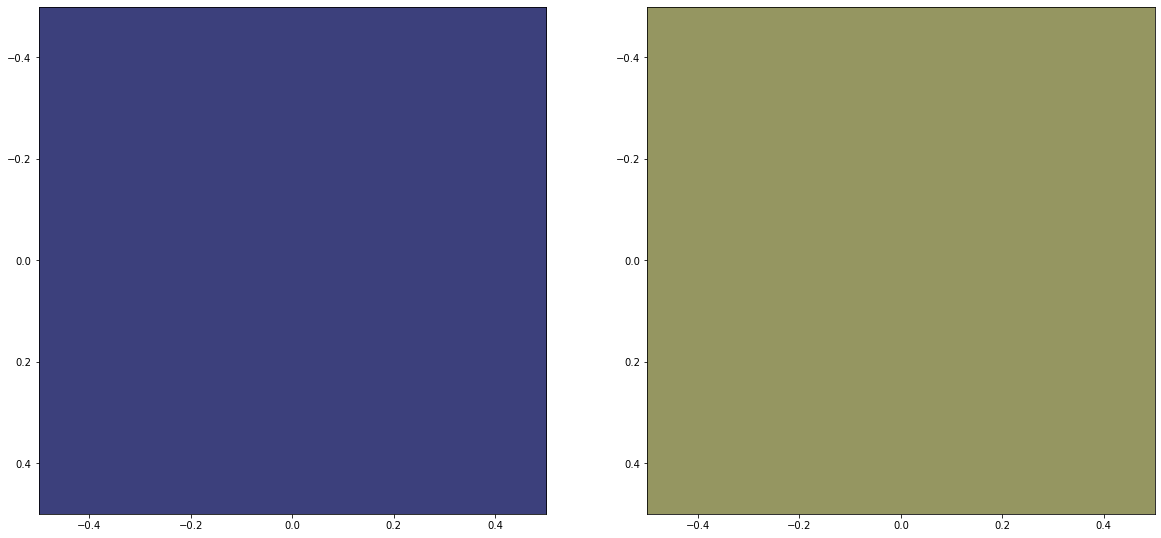

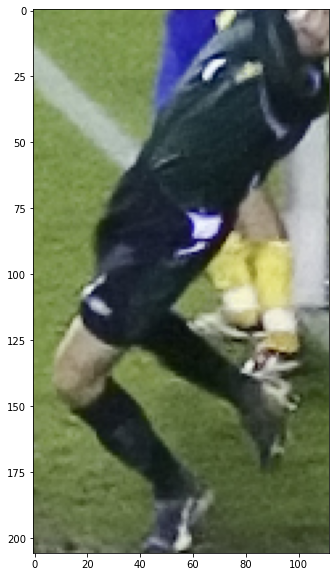

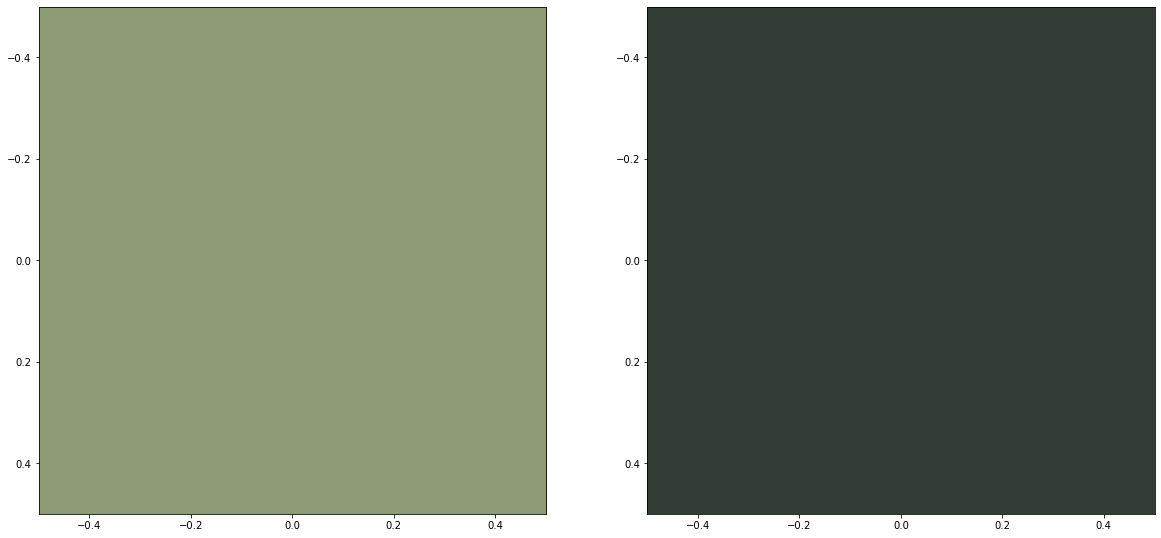

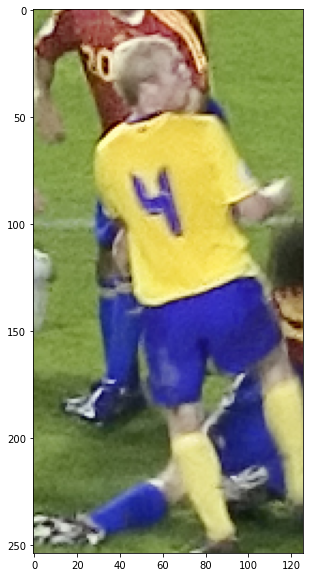

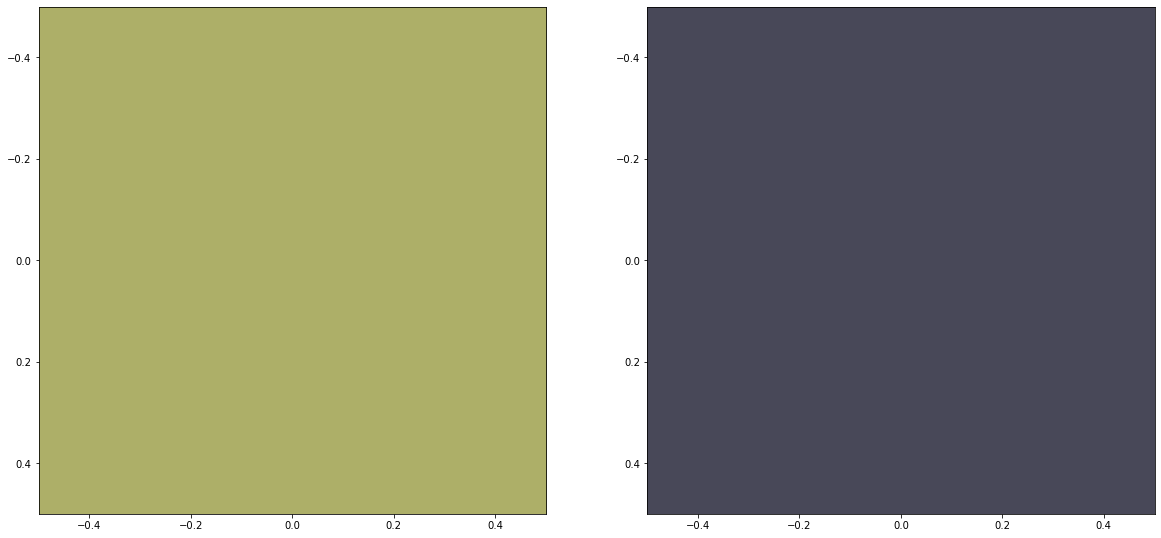

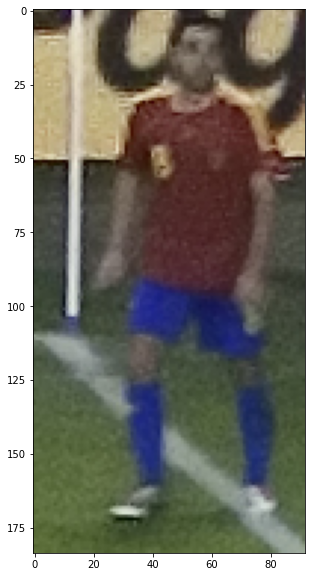

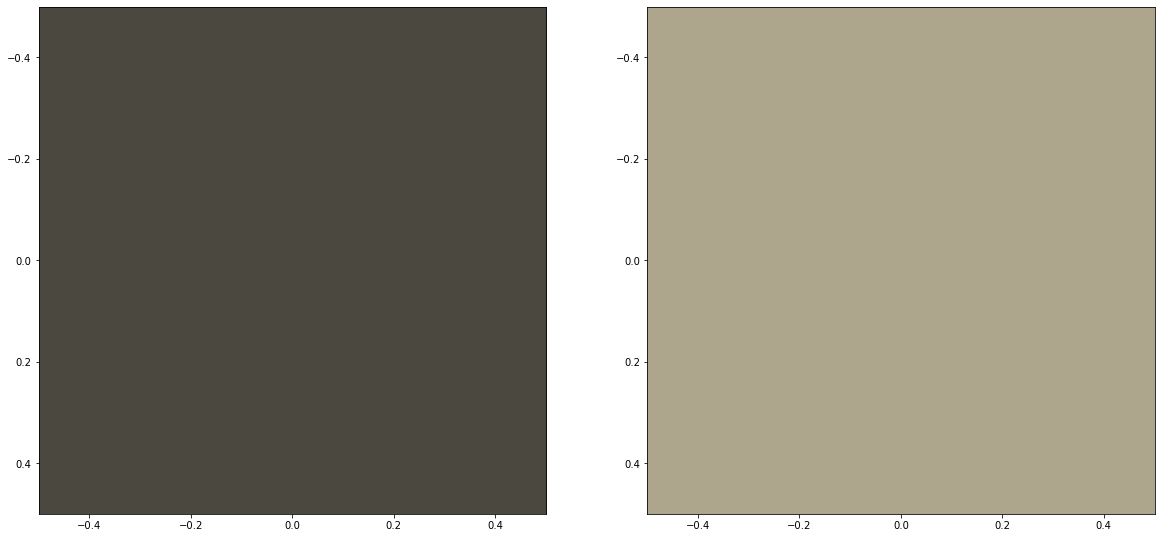

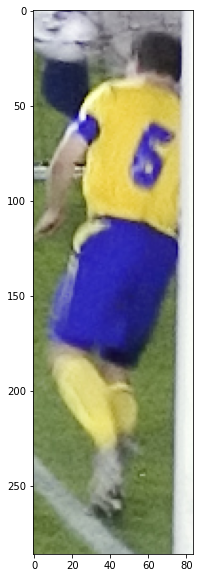

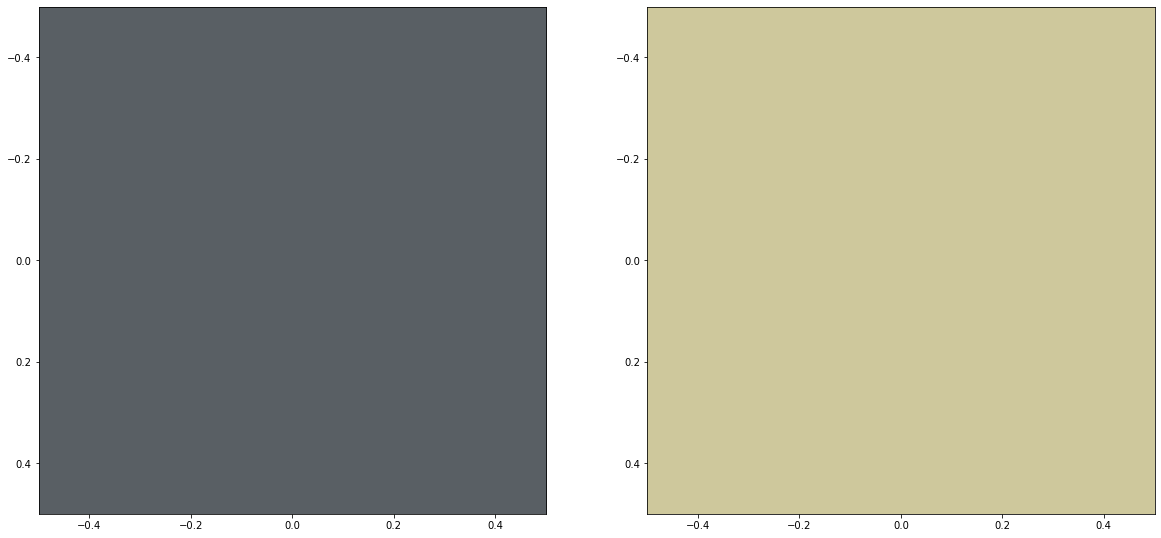

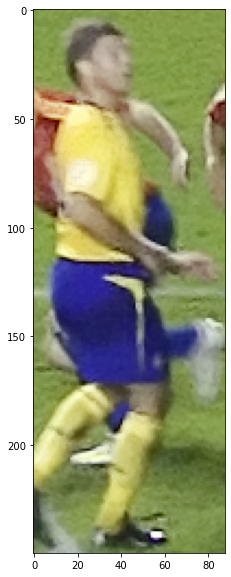

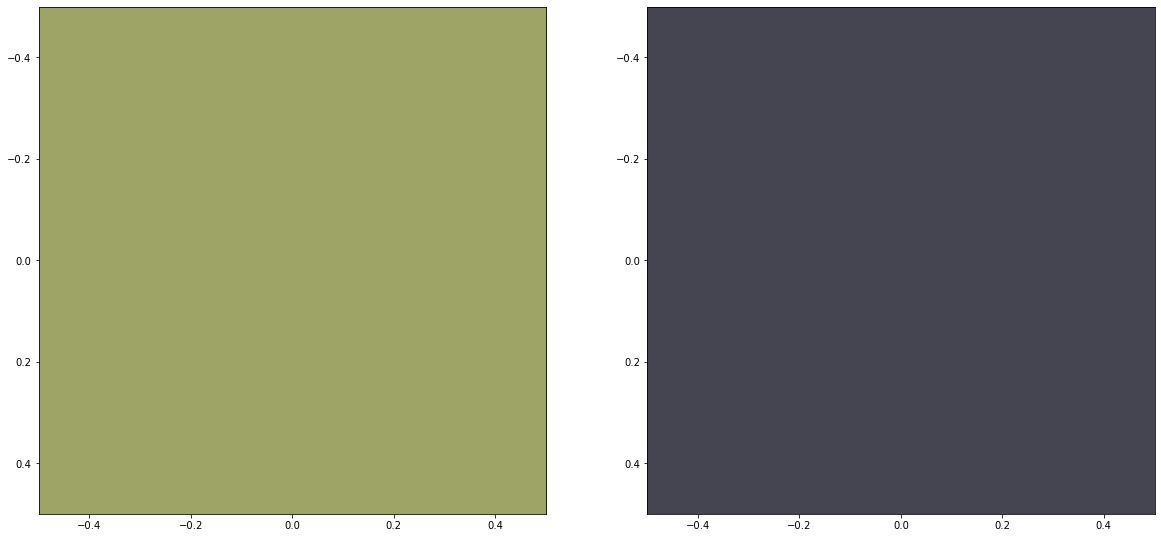

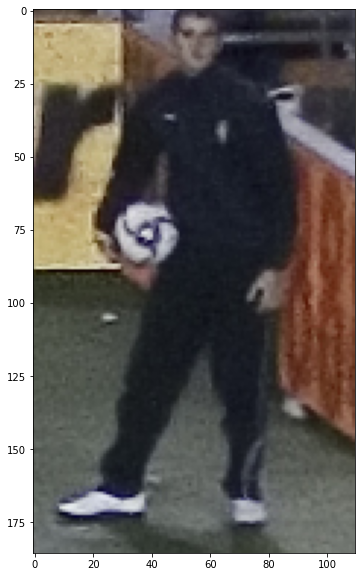

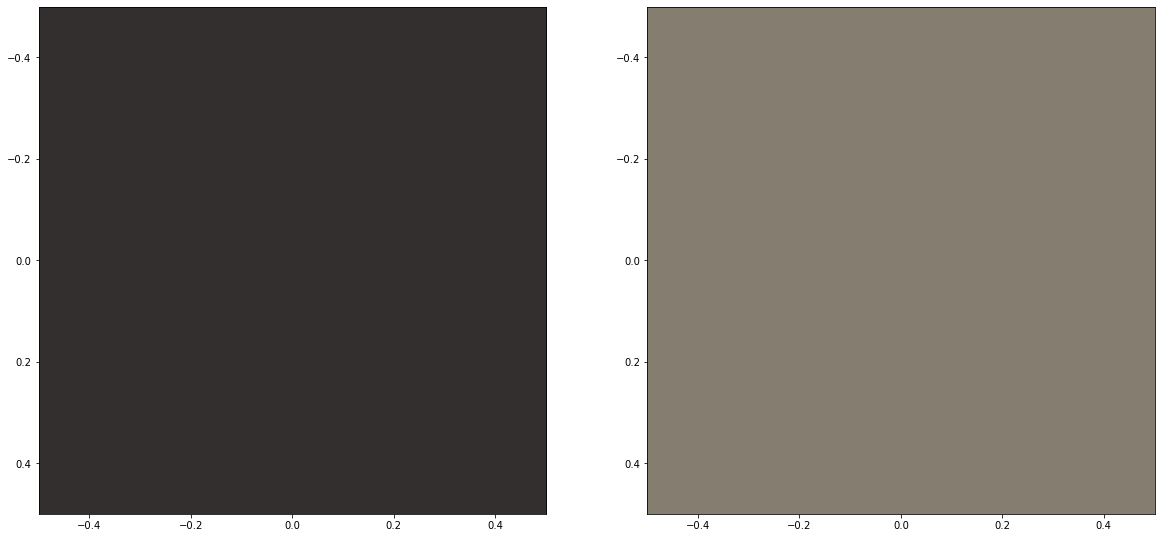

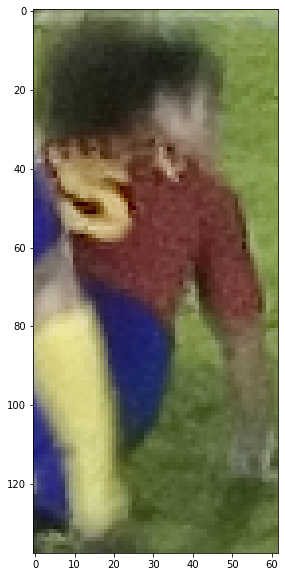

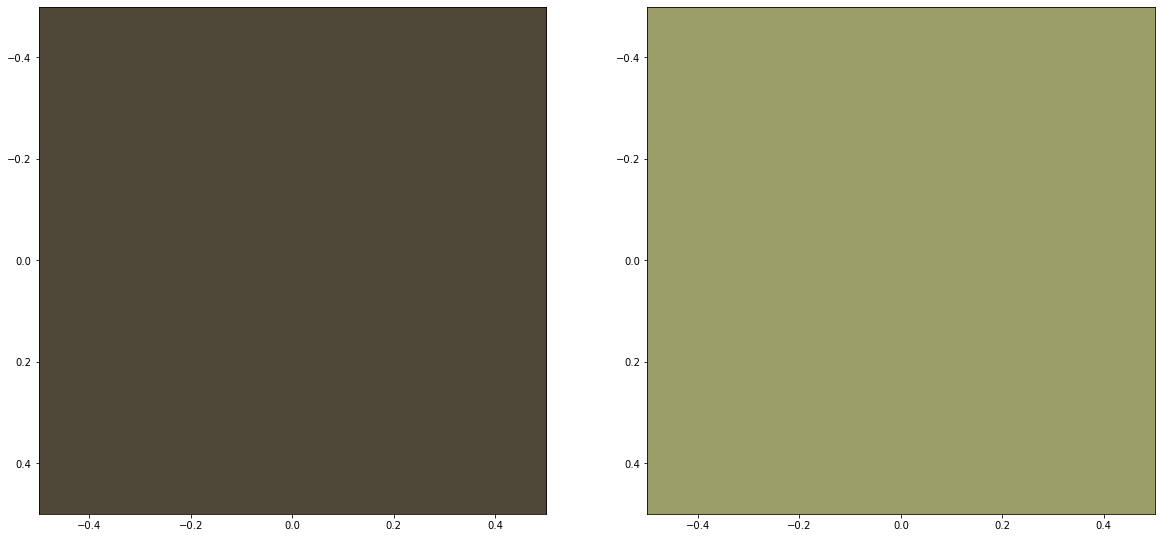

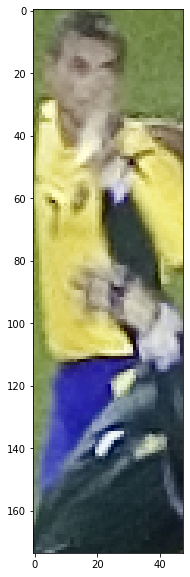

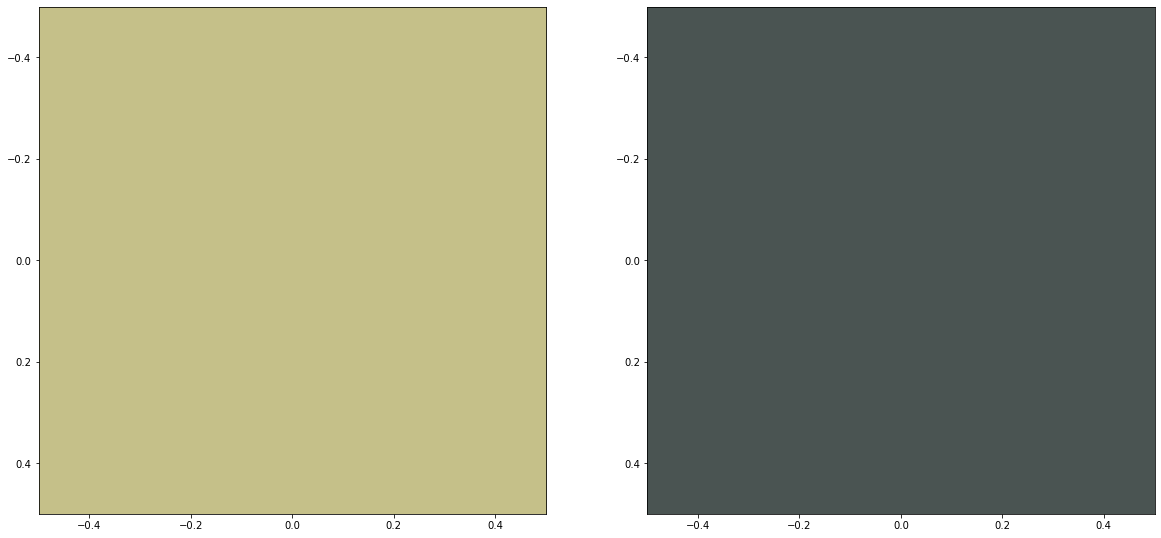

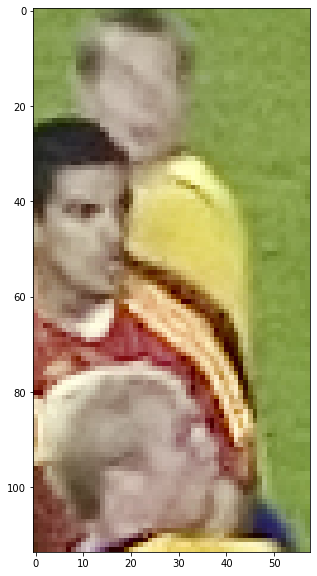

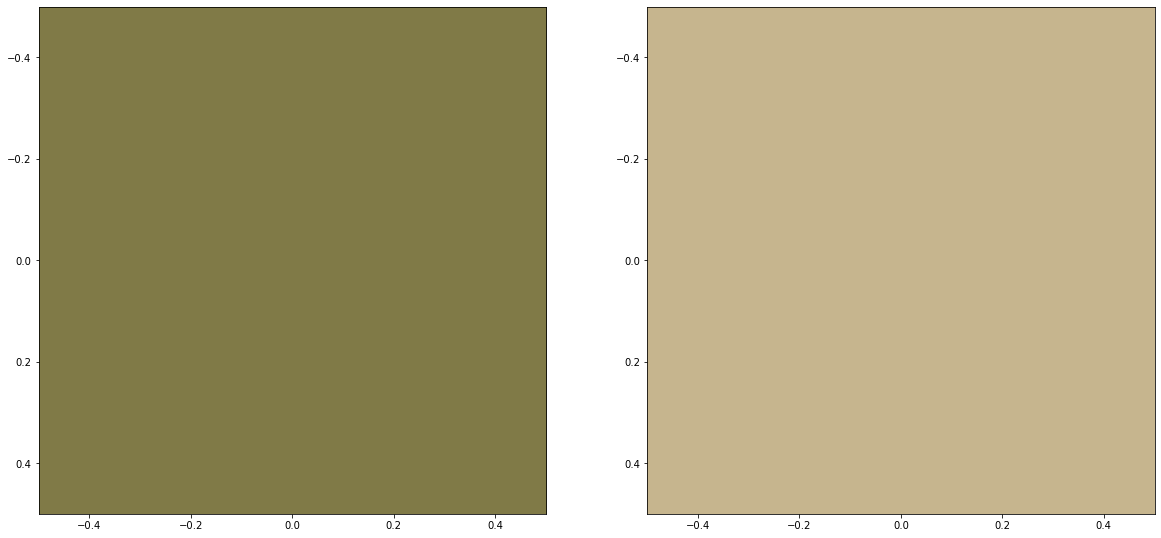

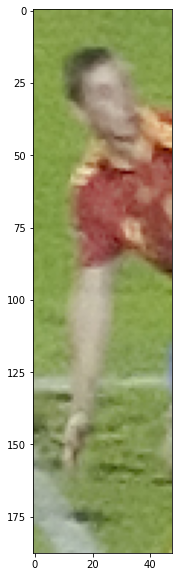

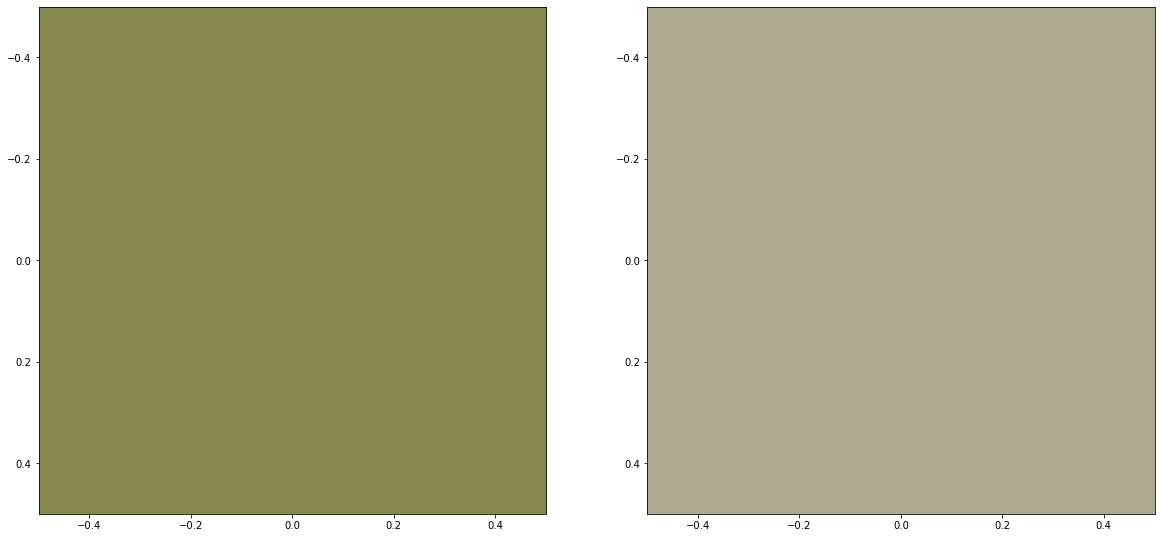

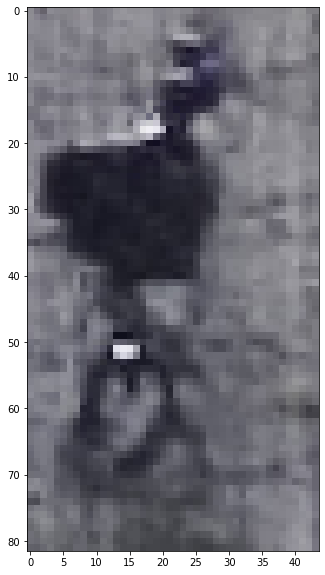

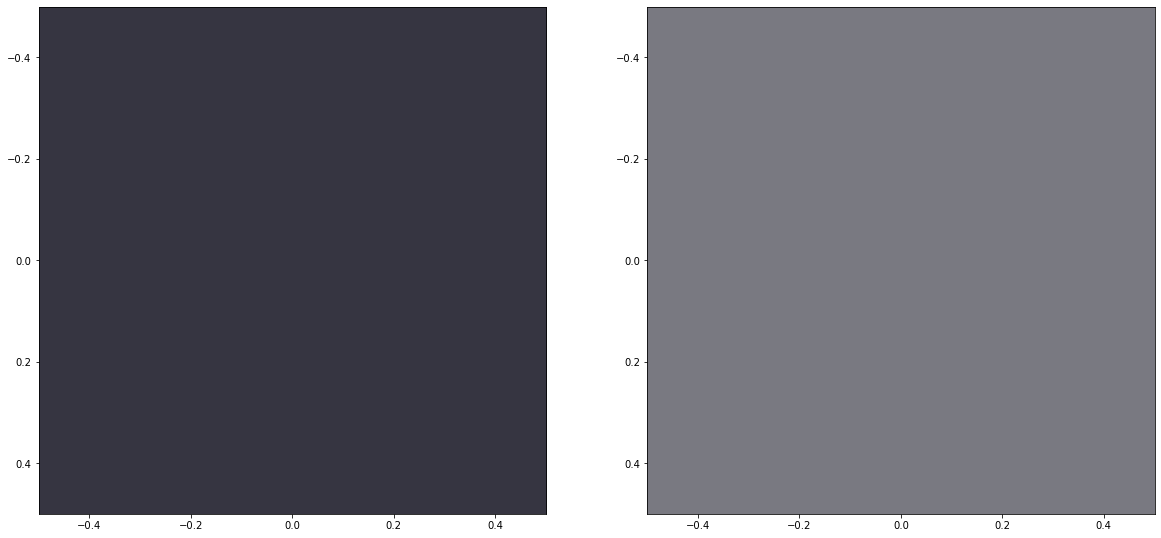

In [20]:
box_color=[]
for i in range(player_number):
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(1,1,1)
    ax1.imshow(get_cropped_box(boxes_player[i]))
    box_color.append(get_team(boxes_player[i])[1])
    print(f"the dominant colors of image {i} {get_team(boxes_player[i])[1]}")
    show_clusters(i)
print(np.shape(box_color))
# clf = svm.SVC()
# clf.fit(np.array(box_color).flatten().reshape(player_number,6).transpose(), ["team a","team b","other"])
